In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import torch
import sys
import os

/n/fs/ragr-research/users/xinhao/miniconda3/envs/multiome/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(os.path.abspath("src/MOSAICField"))
from src.MOSAICField.affine_alignment import affine_align
from src.MOSAICField.nonlinear_alignment import warp_image, warp_image_reverse, nonlinear_align

# Some helper functions used to visualize slices

In [3]:
"""
Visualize the mouse embryo slice given cell coordinates
"""
def visualize_slice(adata, coords):
    # coords: (n_cells, 2) array
    ann = adata.obs["annotation"]                     # categorical
    cats = list(ann.cat.categories)
    palette = list(adata.uns["annotation_colors"])    # must align with `cats`
    
    # Map category -> color
    cat2color = dict(zip(cats, palette))
    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
    
    # Plot category by category (faster & makes a legend)
    for cat in cats:
        mask = (ann == cat).values
        ax.scatter(
            coords[mask, 0],
            coords[mask, 1],
            s=5,                      # marker size
            linewidths=0,
            c=cat2color[cat],
            label=cat
        )
    
    ax.set_aspect("equal")
    ax.invert_yaxis()                 # common for image-like spatial coords
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend(markerscale=3, bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()
    # plt.savefig("e105_spatial.png", bbox_inches="tight", dpi=300)


In [4]:
"""
Plotting overlapping slices for the purpose of visualizing their aligned coordinates
"""
def plot_slices_overlap(slices, colors=['#1f77b4','#ff7f0e'], invert_axis=True, s=1, save_path=None):
    plt.figure()
    for i in range(len(slices)):
        plt.scatter(slices[i][:,0],slices[i][:,1],marker=".", s=s, color=colors[i])
    if invert_axis:
        plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')  # preserve aspect ratio
    plt.axis('off')
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()

# Simulation data generation

First, we load a E10.5 mouse embryo slice. You can download the slice from https://db.cngb.org/stomics/mosta/download/. The slice we use is E10.5_E1S1.MOSTA.h5ad

In [5]:
e10 = sc.read_h5ad('/PATH/TO/E10.5_E1S1.MOSTA.h5ad')

e10.X = e10.layers['count']
del e10.layers['count']

Let's center the coordinates (just for convenience) and visualize this slice.

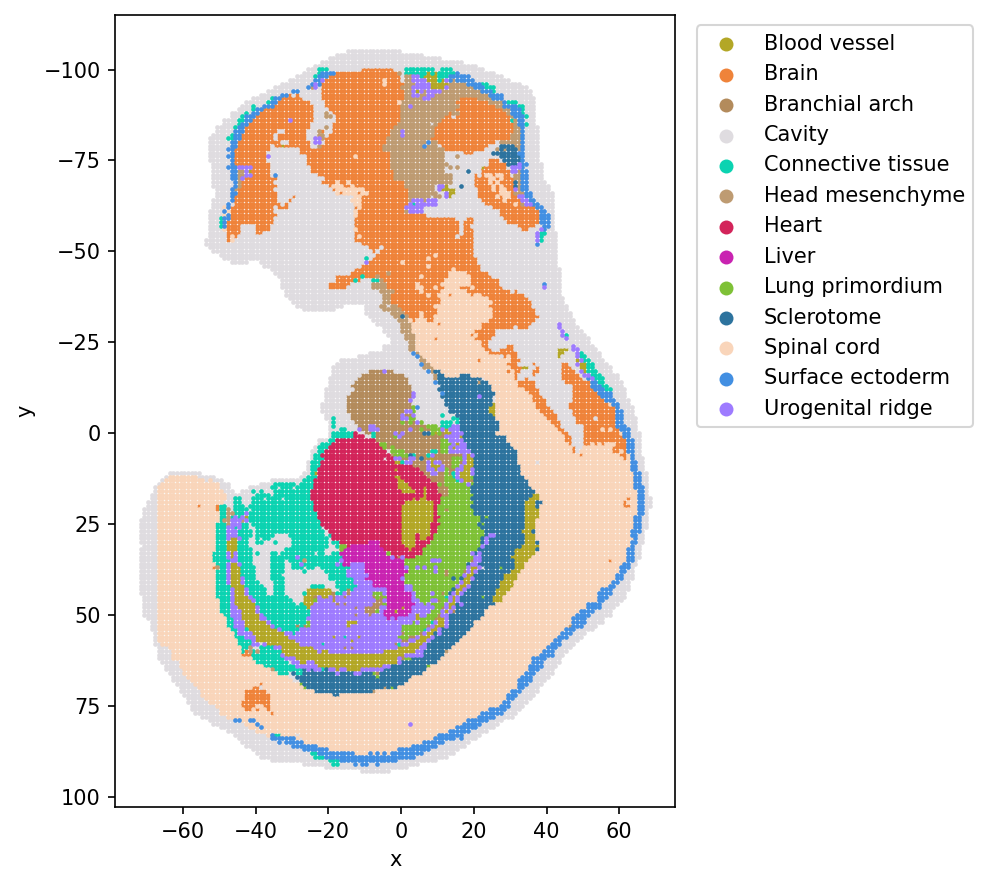

In [6]:
coords = np.asarray(e10.obsm["spatial"], dtype=float)
coords = coords - coords.mean(axis=0)
e10.obsm['spatial'] = coords
visualize_slice(e10, coords)

Now, we will simulate a globally distorted slice from this slice, and our goal is to use MOSAICField to align the two slices to correct for the global distortion.

We perform a sinusoidal warping of the slice coordinates followed by scaling and rotation to generate the other slice.

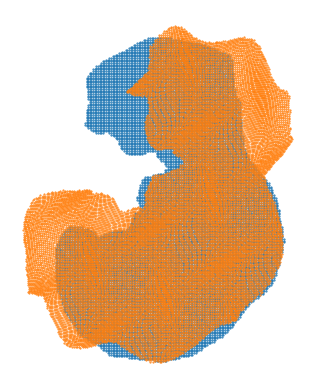

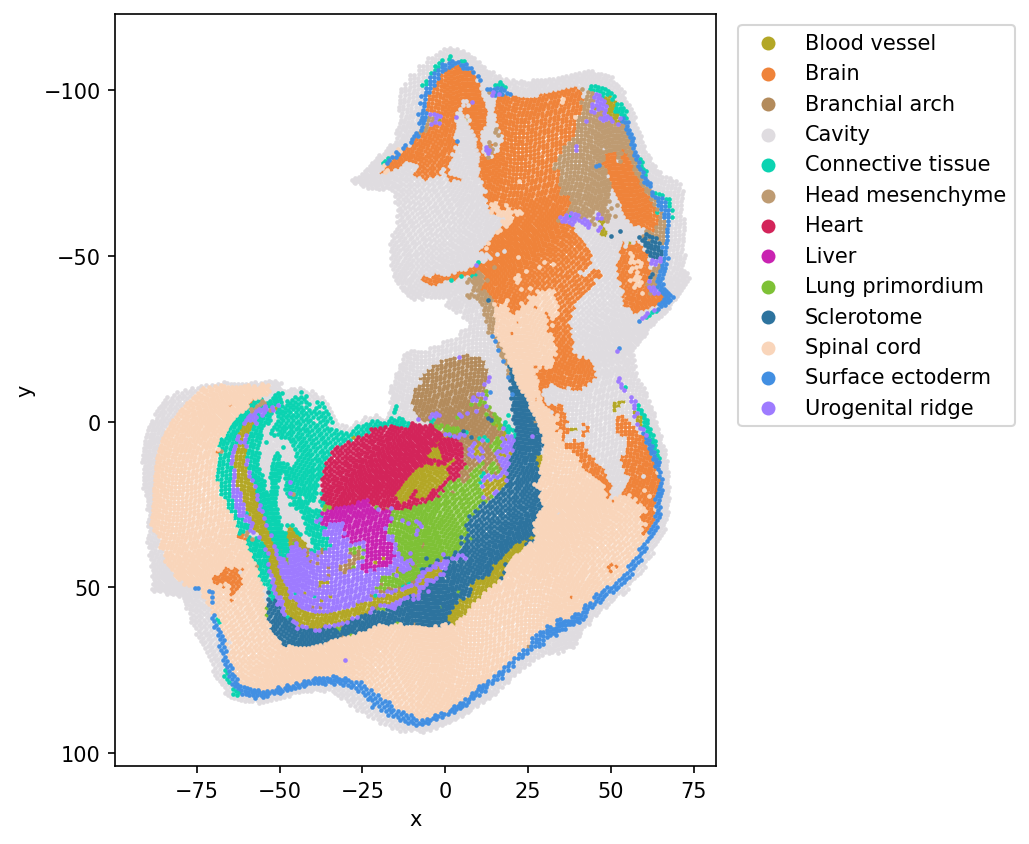

In [7]:
def rotate_coords(coords, angle_deg=25, center=None):
    """Rotate 2D coordinates clockwise by `angle_deg` degrees."""
    theta = np.deg2rad(-angle_deg)  # negative for clockwise
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])
    if center is None:
        center = coords.mean(axis=0)  # rotate around centroid
    rotated = (coords - center) @ R.T + center
    return rotated

def warp_sine(coords, ax=0.05, ay=0.05, freq=2.0, keep_centroid=True, keep_scale=True, random_phase=True, seed=0):
    rng = np.random.default_rng(seed)
    P = coords.astype(float).copy()
    # center & scale helpers
    mean0 = P.mean(axis=0)
    span0 = P.ptp(axis=0)  # range in each dim

    P -= mean0  # work in centered coords for nicer behavior
    Lx, Ly = np.maximum(span0, 1e-8)  # avoid divide by zero

    # Optional random phases so the ripple doesn't align to axes too neatly
    phx = rng.uniform(0, 2*np.pi) if random_phase else 0.0
    phy = rng.uniform(0, 2*np.pi) if random_phase else 0.0

    x, y = P[:,0], P[:,1]
    # frequencies are in “cycles across the span”
    Xp = x + ax * Lx * np.sin(2*np.pi*freq * (y/Ly) + phy)
    Yp = y + ay * Ly * np.sin(2*np.pi*freq * (x/Lx) + phx)
    Q = np.c_[Xp, Yp]

    # restore centroid / scale if requested
    if keep_scale:
        scale = span0 / np.maximum(Q.ptp(axis=0), 1e-8)
        Q = (Q - Q.mean(axis=0)) * scale + Q.mean(axis=0)
    if keep_centroid:
        Q += mean0
    return Q


coords_transformed = warp_sine(coords, ax=0.03, ay=0.03, freq=3.0)
coords_transformed *= 1.1
coords_transformed = rotate_coords(coords_transformed, angle_deg=-25)
plot_slices_overlap([coords, coords_transformed])
visualize_slice(e10, coords_transformed)

In [8]:
e10_transformed = e10.copy()
e10_transformed.obsm['spatial'] = coords_transformed

Now, to simulate multimodality, we split the gene set into two half and assign each slice one half. Then we use the PCA embedding as the feature of each cell. We also apply a random projection on the transformed slice. See paper for details.

We define the transformed slice to be the source slice, and the original slice to be the target slice, and this tutorial shows how to use MOSAICField to align the source slice onto the target slice.

In [9]:
# Split into two AnnData objects
e10_even = e10[:, 0::2].copy()
e10_transformed_odd = e10_transformed[:, 1::2].copy()

sc.pp.normalize_total(e10_even, inplace=True)
sc.pp.log1p(e10_even)
sc.pp.highly_variable_genes(e10_even, flavor="seurat", n_top_genes=2000, inplace=True, subset=True)
sc.pp.pca(e10_even, 50)

sc.pp.normalize_total(e10_transformed_odd, inplace=True)
sc.pp.log1p(e10_transformed_odd)
sc.pp.highly_variable_genes(e10_transformed_odd, flavor="seurat", n_top_genes=2000, inplace=True, subset=True)
sc.pp.pca(e10_transformed_odd, 50)
W = np.random.randn(50, 50)
e10_transformed_odd.obsm['X_pca'] = e10_transformed_odd.obsm['X_pca'] @ W

/n/fs/ragr-research/users/xinhao/miniconda3/envs/multiome/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/n/fs/ragr-research/users/xinhao/miniconda3/envs/multiome/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
/n/fs/ragr-research/users/xinhao/miniconda3/envs/multiome/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default a

In [10]:
source_slice = e10_transformed_odd
target_slice = e10_even

# Step 1: Affine alignment

The first step of MOSAICField is to compute an affine transformation registering the source slice onto the target slice.

In this simulation, the number of cells in each slice is very large. To save computation resource, let's randomly downsample each slice to 2000 cells first. In practice we do not observe a performance drop.

In [11]:
source_randomindices = np.random.choice(source_slice.shape[0], 2000, replace=False)
target_randomindices = np.random.choice(target_slice.shape[0], 2000, replace=False)

source_slice_subsampled = source_slice[source_randomindices]
target_slice_subsampled = target_slice[target_randomindices]

Now, we use the `affine_align` function to compute an affine transformation from souce slice to target slice. The returned `T` stores the computed affine parameters.

In [12]:
source_slice_subsampled_aligned, target_slice_subsampled_aligned, T, P = affine_align(source_slice_subsampled, 
                                                                                      target_slice_subsampled, 
                                                                                      obsm_name='X_pca',
                                                                                      max_iter=10,
                                                                                     alpha=0.9)

Iter: 0
Iter: 1
Iter: 2
Iter: 3
Iter: 4
Iter: 5
Iter: 6
Iter: 7
Iter: 8
Iter: 9


Because of the downsampling, we need an extra step to apply `T` to all the cells in the source slice, not just the downsampled ones.

In [13]:
def affine_transform(X, T):
    homogeneous_X = np.vstack([X.T, np.ones((1, X.shape[0]))])
    transformed_homogeneous_X = T @ homogeneous_X
    return transformed_homogeneous_X[:2, :].T


source_slice.obsm['spatial'] = affine_transform(source_slice.obsm['spatial'], T)

Visualizing the slice coordinates after affine transformation: the global scaling and rotation are corrected by the affine alignment step of MOSAICField! Next we will use nonlinear alignment to correct for the nonlinear distortions.

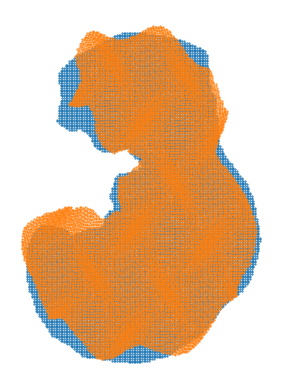

In [14]:
plot_slices_overlap([target_slice.obsm['spatial'], source_slice.obsm['spatial']])

# Step 2: Nonlinear alignment

In this step, we see how MOSAICField nonlinear alignment works on this pair of simulated slices. 

Since the nonlinear alignment step works with images, we first use the following function to rasterize source and target slices into images:

## Rasterization

In [15]:
"""
Function to rasterize a slice into an image
"""

def rasterize(slice_adata, target_size, translation=None):
    # --- Rasterize with translation-only mapping ---
    # Coordinates: no scaling—just translate so min corner maps to (0,0), then (optionally) pad to a target canvas.
    coords = np.asarray(slice_adata.obsm["spatial"], dtype=float)    # shape: (n_obs, 2), columns [x, y]
    x, y = coords[:, 0], coords[:, 1]
    
    # Translate so the minimum becomes 0; DO NOT scale.
    if translation is None:
        x_min, y_min = x.min(), y.min()
    else:
        x_min, y_min, x_off, y_off = translation
    x_pix = np.rint(x - x_min).astype(np.int32)   # round to nearest integer pixel
    y_pix = np.rint(y - y_min).astype(np.int32)
    
    # Tight bounding box size implied by original coordinates (translation only)
    W_bb = int(x_pix.max() + 1)
    H_bb = int(y_pix.max() + 1)
    
    # Choose final canvas size: large enough to fit original shape
    target_H, target_W = target_size
    H, W = target_H, target_W
    
    # Optional: center the translated content on the canvas (still translation only, no scaling)
    if translation is None:
        H = max(H_bb, target_H)
        W = max(W_bb, target_W)
        x_off = (W - W_bb) // 2
        y_off = (H - H_bb) // 2
    x_pix += x_off
    y_pix += y_off
    
    # --- Scatter-aggregate features onto the canvas (mean if multiple cells fall in the same pixel) ---
    img = np.zeros((H, W, 50), dtype=np.float32)
    cnt = np.zeros((H, W), dtype=np.int32)
    
    # Accumulate sums
    np.add.at(img, (y_pix, x_pix, slice(None)), slice_adata.obsm['X_pca'])
    np.add.at(cnt, (y_pix, x_pix), 1)
    
    # Average where we have at least one cell
    mask = cnt > 0
    img[mask] /= cnt[mask][..., None]
    
    # --- Normalize only non-empty pixels ---
    img_uint8 = np.zeros_like(img, dtype=np.uint8)
    mask = cnt > 0  # pixels with cells
    
    for c in range(img.shape[2]):
        ch = img[..., c]
        if np.any(mask):
            # compute min/max only over pixels that contain cells
            vmin, vmax = ch[mask].min(), ch[mask].max()
            if vmax > vmin:
                ch_norm = np.zeros_like(ch)
                ch_norm[mask] = (ch[mask] - vmin) / (vmax - vmin)
                img_uint8[..., c] = (ch_norm * 255).astype(np.uint8)
            else:
                img_uint8[..., c] = 0
        else:
            img_uint8[..., c] = 0

    slice_adata = slice_adata.copy()
    slice_adata.obsm['spatial'] = np.stack((x_pix, y_pix), axis=1)

    return img_uint8, slice_adata, (x_min, y_min, x_off, y_off)

Rasterizer target slice:

(400, 400, 50)


(-0.5, 399.5, 399.5, -0.5)

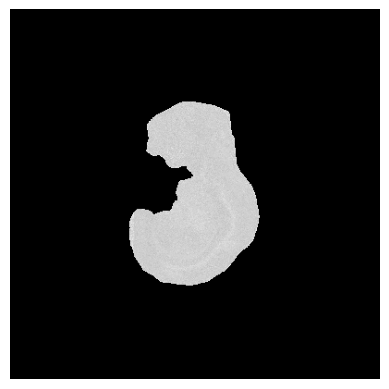

In [16]:
img_target, slice_target_pixel, translation = rasterize(target_slice, target_size=[400, 400])

print(img_target.shape)
plt.imshow(img_target.mean(axis=2), cmap='gray')
plt.axis("off")

Rasterize source slice:

(400, 400, 50)


(-0.5, 399.5, 399.5, -0.5)

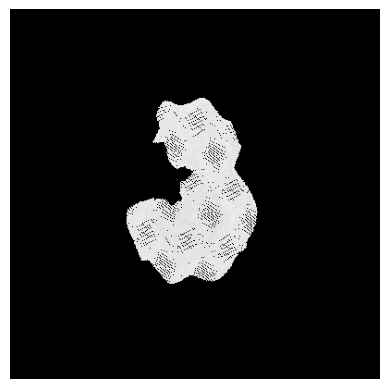

In [17]:
img_source, slice_source_pixel, _ = rasterize(source_slice, target_size=[400, 400], translation=translation)

print(img_source.shape)
plt.imshow(img_source.mean(axis=2), cmap='gray')
plt.axis("off")

## Learning neural field

We first define the config with parameters needed for nonlinear alignment.

In [18]:
from types import SimpleNamespace
config = {
    "epoches": 1000,
    "lr": 0.005,
    "lambda_J": 2.5,
    "lambda_v": 0.000005,
    "device": "cuda:1"
}
config = SimpleNamespace(**config)

Then we use the `nonlinear_align` function to aligned the source image with the target image. `nonlinear_align` takes in both images as pytorch tensors of shape (C, H, W).

`nonlinear_align` returns the warped source image, the deformation field, and the neural network. The warped source image is also a pytorch tensor of shape (C, H, W). We can convert it to a numpy array of shape (H, W, C) and plot.

source.shape torch.Size([50, 400, 400])
target.shape torch.Size([50, 400, 400])
grid.shape torch.Size([2, 400, 400])
grid_batch.shape torch.Size([160000, 2])
scale_factor.shape torch.Size([2])
Total parameters: 8642
Iteration: 1 Loss: 6.007e-01
Iteration: 501 Loss: 4.260e-02
Source:


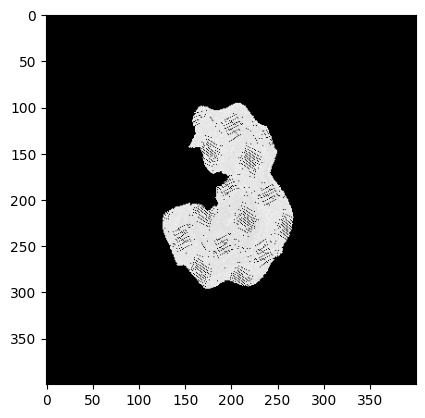

Target:


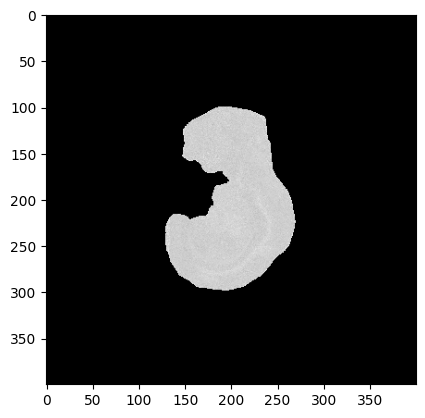

Warped source:


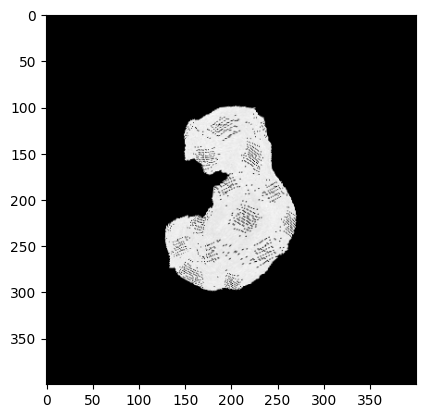

In [19]:
source = torch.from_numpy(img_source).permute(2, 0, 1)
target = torch.from_numpy(img_target).permute(2, 0, 1)
    
warped_source, pred_field, network = nonlinear_align(config, source, target)
warped_source = warped_source.permute(1, 2, 0).detach().cpu().numpy()  # [H, W, C]

print("Source:")
plt.imshow(img_source.mean(axis=2), cmap='gray')
plt.show()
print("Target:")
plt.imshow(img_target.mean(axis=2), cmap='gray')
plt.show()
print("Warped source:")
plt.imshow(warped_source.mean(axis=2), cmap='gray')
plt.show()

As we can see, the warped source image is successfully aligned with the target image, with the nonlinear distortion corrected.

We can further apply the learned deformation field to the original point cloud coordinates (that is, we can move freely between point clouds and images!), The `warp_image_reverse` function, when passing in the learned deformation field, returns a `phi` that applies the deformation field to the source slice coordinates.

In [20]:
back_warped_source, phi = warp_image_reverse(torch.from_numpy(warped_source).permute(2, 0, 1).unsqueeze(0), pred_field, config.device)

# get the corresponding mapped positions of each point in the source slice.
source_coords = slice_source_pixel.obsm['spatial'].astype(int)
x = source_coords[:, 0]
y = source_coords[:, 1]
phi = phi.detach().cpu().numpy()
sourcecoords_mapped = phi[0, :, y, x][:, ::-1]   # shape (N, 2)

Now let's visualize the source slice after MOSAICField nonlinear warping:

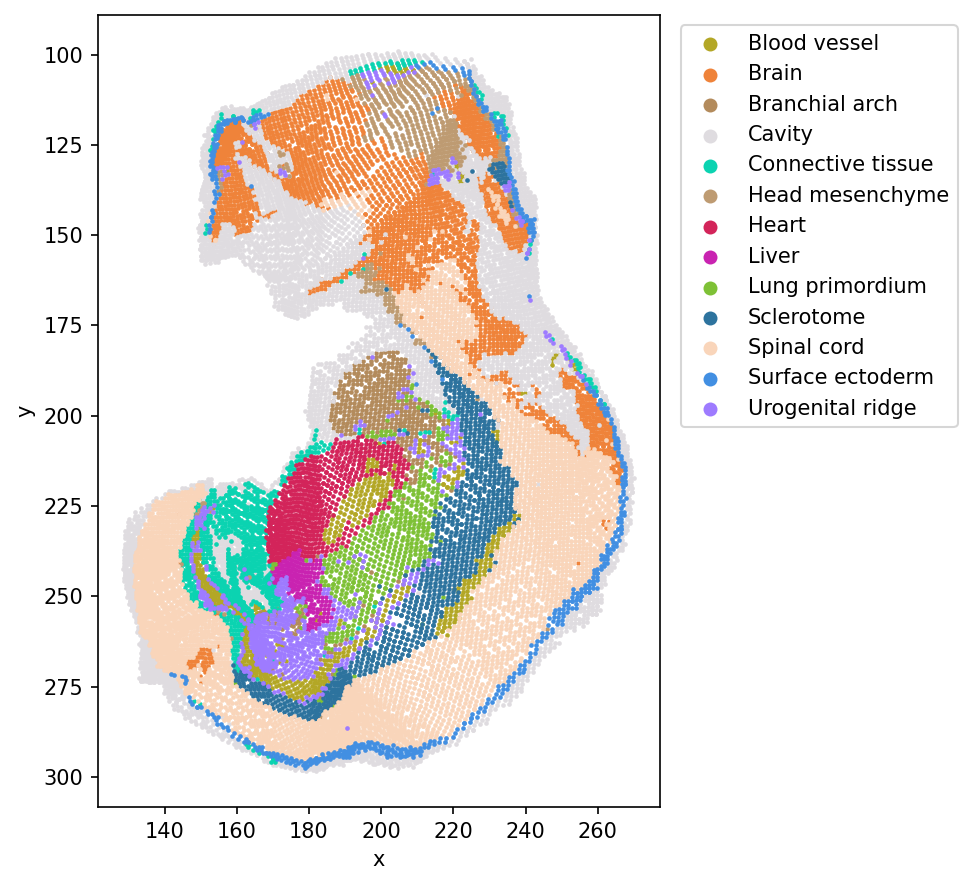

In [21]:
visualize_slice(slice_source_pixel, sourcecoords_mapped)

And plot the warped source slice and target slice together. Now the two slices are aligned!

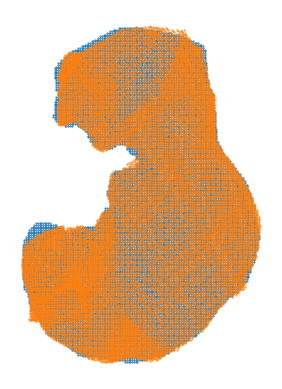

In [22]:
plot_slices_overlap([slice_target_pixel.obsm['spatial'], sourcecoords_mapped])